### The purpose of this notebook is to compare and explore different imputation methods - it is not involved in the actual pipeline of the project

In [1]:
import numpy as np
import torch

from imputation_utils import *

# Import data

In [2]:
data, VARIABLES = import_data(discard_variables=True, discard_days=True, THRESHOLD=60)

discarded variables: ['GalvanicSkinResponse', 'ActivityClass']
discarded days (less than 60min of data): [312]
discarded days (sensor out all day): [114]


# Imputation

Format data into daily dataframes (for imputation model)

In [3]:
data_daily = data_to_days(data)

100%|██████████| 408/408 [02:04<00:00,  3.28it/s]


Normalize day-variable-wise

In [4]:
normalize_by_day(data_daily)

day 0 - ActivityCounts: mean: 1.2688263138573217e-17, std: 0.9999999999999959
day 0 - Barometer: mean: -5.938107148852266e-14, std: 0.9999999999999997
day 0 - BloodPerfusion: mean: 2.3770417019099194e-16, std: 1.000000000000001
day 0 - BloodPulseWave: mean: 1.092154295472125e-16, std: 1.0000000000000004
day 0 - EnergyExpenditure: mean: -5.075305255429287e-17, std: 1.0000000000000064
day 0 - HR: mean: -9.765144288927236e-16, std: 1.0
day 0 - HRV: mean: 1.5650721051984586e-16, std: 0.9999999999999997
day 0 - RESP: mean: -3.760906729921135e-16, std: 0.9999999999999998
day 0 - Steps: mean: -3.6478756523398e-17, std: 0.9999999999999938
day 0 - SkinTemperature: mean: 2.816794416763254e-15, std: 0.999999999999999
day 1 - ActivityCounts: mean: 0.0, std: 0.9999999999999909
day 1 - Barometer: mean: 7.088903107932162e-14, std: 0.9999999999999981
day 1 - BloodPerfusion: mean: -3.120978341552417e-17, std: 0.9999999999999994
day 1 - BloodPulseWave: mean: 6.241956683104833e-17, std: 0.999999999999999

### Explore imputation methods

In [5]:
# choose day
day = 400
data_day = data_daily[day]

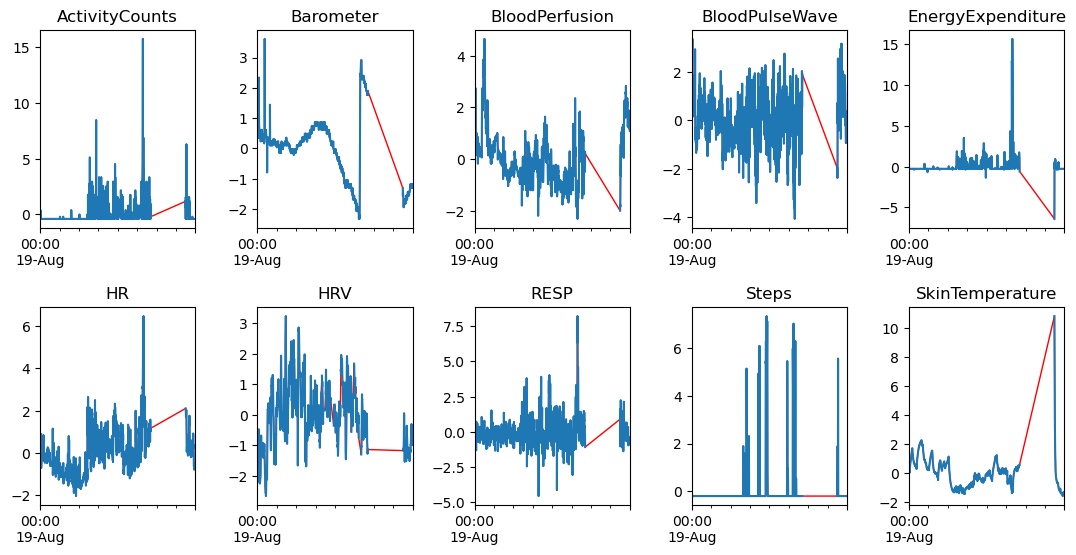

In [6]:
visualize_imputation(data_day, 'linear')

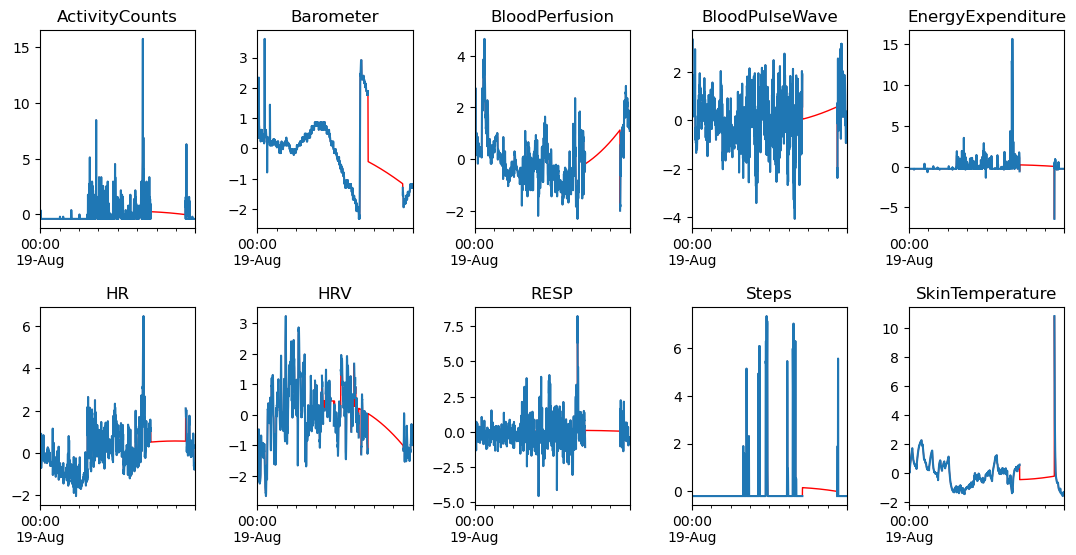

In [7]:
visualize_imputation(data_day, 'spline', order=2)

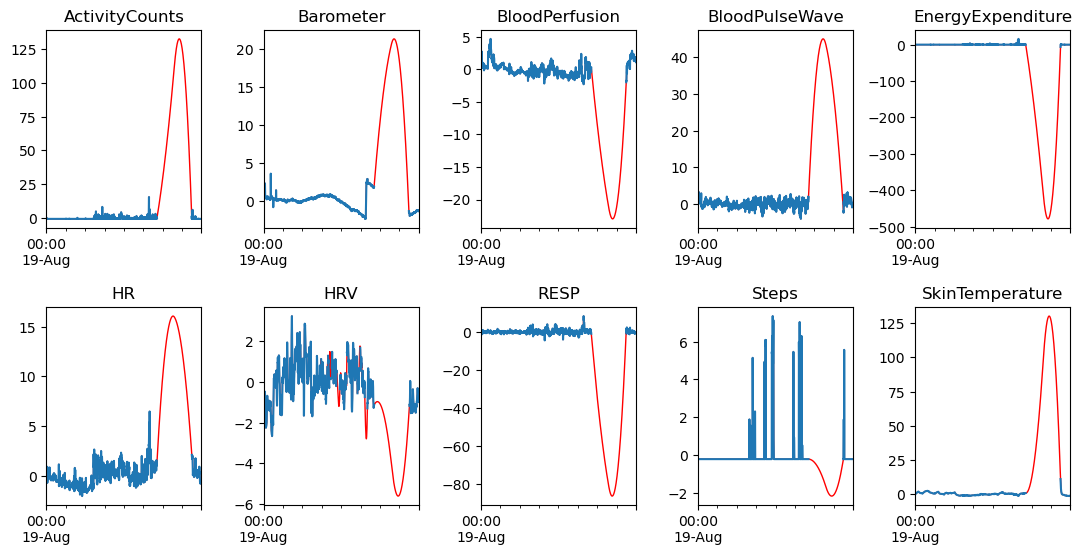

In [8]:
visualize_imputation(data_day, 'quadratic')

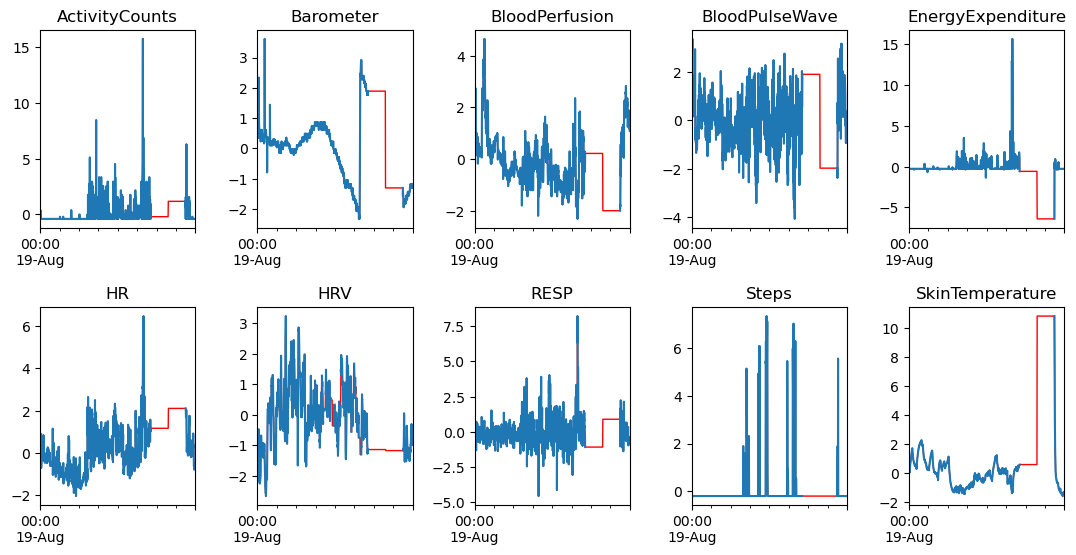

In [9]:
visualize_imputation(data_day, 'nearest')

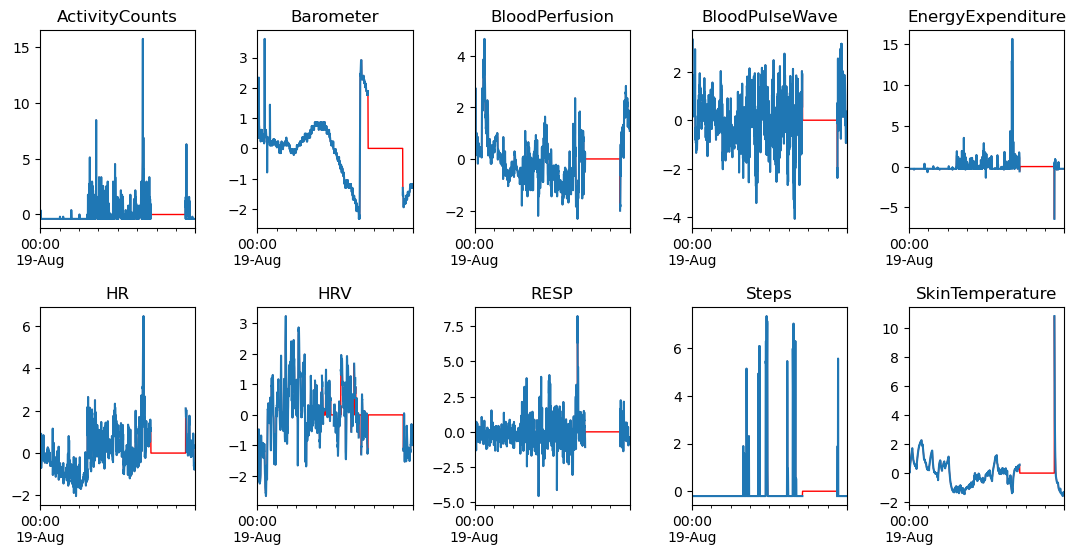

In [10]:
visualize_imputation(data_day, 'mean')

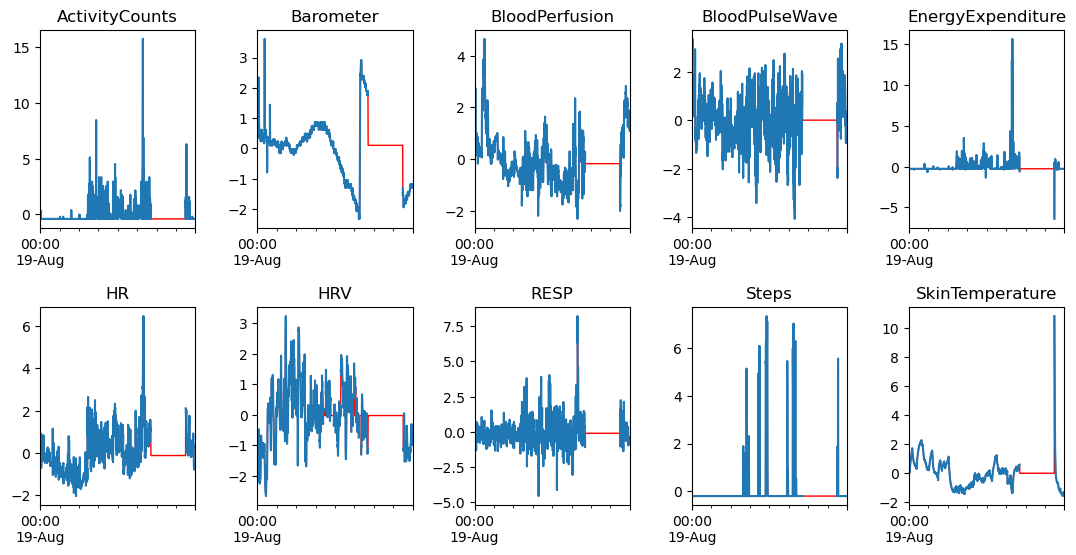

In [11]:
visualize_imputation(data_day, 'median')

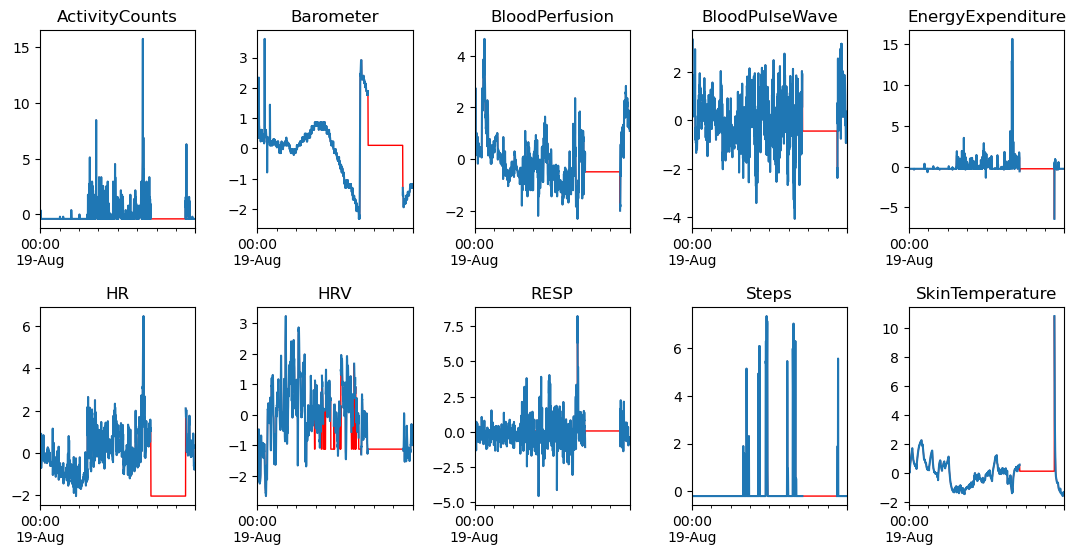

In [12]:
visualize_imputation(data_day, 'mode')

Note: general problem are long missing sequences, e.g.:

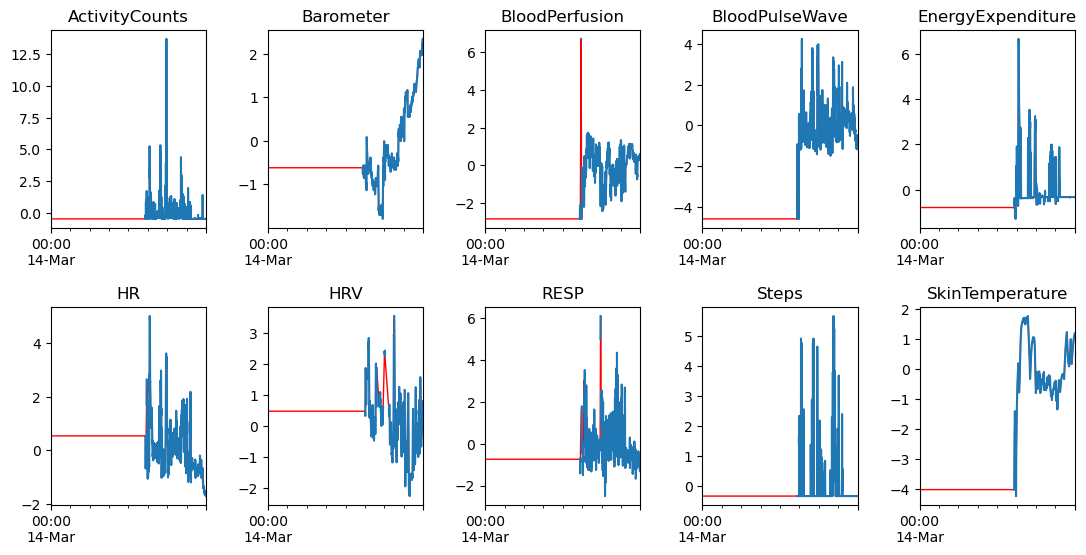

In [13]:
visualize_imputation(data_daily[0], 'linear')

### Scoring of methods

Visualize mask

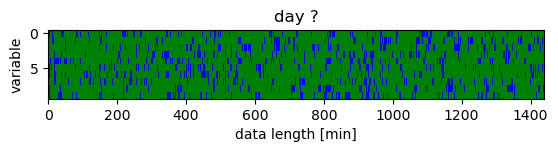

In [54]:
mask = masker(data_day, lm=3, masking_ratio=0.15)
visualize_mask(mask)

Numerical analysis

In [17]:
# short sequences
test_imputation_methods(data_daily, lm=3, masking_ratio=0.15)

[('linear', (0.2961292870438904, 0.0012682778780982533)),
 ('nearest', (0.31782201184574554, 0.001361184605617536)),
 ('quadratic', (0.45839719304728455, 0.0019632472867772708)),
 ('spline', (0.5595774404830617, 0.0023965873012159107)),
 ('median', (0.6141043227300564, 0.0026301178621606714)),
 ('mean', (0.7001167373315408, 0.002998496295006152)),
 ('mode', (0.789170780174581, 0.0033799015711290163))]

In [21]:
# long sequences
test_imputation_methods(data_daily, lm=200, masking_ratio=0.15)

[('spline', (0.6965643814075183, 0.003312635568380723)),
 ('mean', (0.8726121899906409, 0.004149862173722675)),
 ('median', (0.8888592057215736, 0.004227127741166097)),
 ('mode', (1.1733940265204985, 0.0055802835914792615)),
 ('linear', (1.6051672975347757, 0.007633658029241672)),
 ('nearest', (1.7186798249356803, 0.008173487003794187)),
 ('quadratic', (4134.104109745407, 19.660465971083813))]

### Calculate mean sequence length & masking ratio in actual data

Mean sequence length: lm

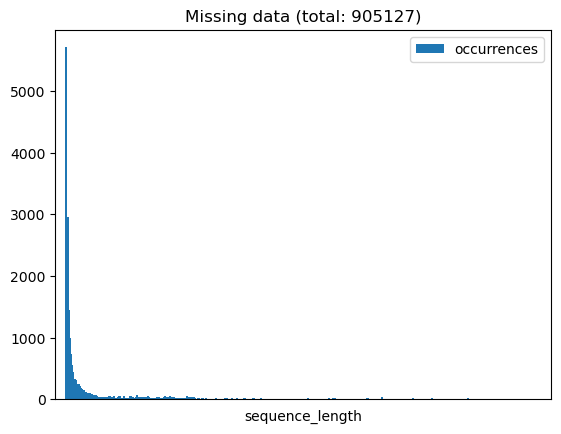

In [45]:
na_seqs = na_sequence_lengths(data)

In [46]:
na_distribution = [[seq_length]*occurence for seq_length, occurence in na_seqs.to_numpy()]
na_distribution = [element for sublist in na_distribution for element in sublist]

In [47]:
lm = np.mean(na_distribution) # mean masked sequence
lm

43.43845083265345

Masking ratio: masking_ratio

In [48]:
# NaN -> 1.0, available data -> NaN
na_flipped = data.copy(deep=True)
n_days, _ = na_flipped.shape
for day in range(n_days):
    for variable in VARIABLES:
        time_series = get_time_series(na_flipped, variable, day)
        nas = np.isnan(time_series)
        time_series[:] = 1.0 # set full array to 1.0
        time_series[~nas] = np.NaN # set all elements that weren't NaN to NaN

        na_flipped[variable].iloc[day] = time_series

/var/folders/tq/31s58g8x49x32phm81cky_s40000gn/T/ipykernel_35668/2278000663.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_flipped[variable].iloc[day] = time_series


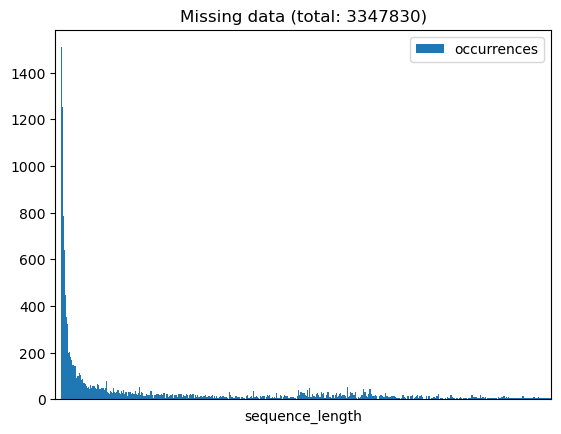

In [49]:
non_na_seqs = na_sequence_lengths(na_flipped)

In [50]:
non_na_distribution = [[seq_length]*occurence for seq_length, occurence in non_na_seqs.to_numpy()]
non_na_distribution = [element for sublist in non_na_distribution for element in sublist]

In [51]:
np.mean(non_na_distribution) # mean unmasked sequence

161.50465531381155

In [52]:
r = lm / (np.mean(non_na_distribution) + lm) # masking_ratio
r

0.21195370583292347

Visualize

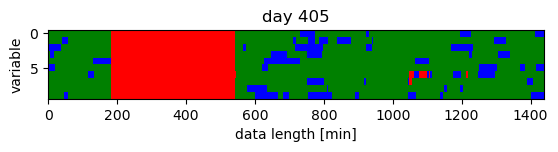

In [53]:
visualize_mask(masker(data_day, lm=lm, masking_ratio=r))

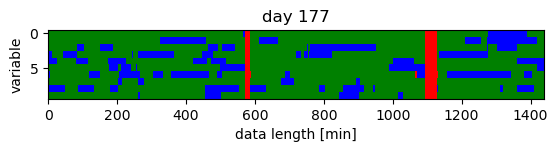

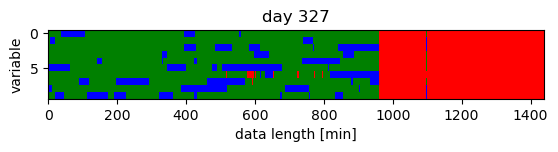

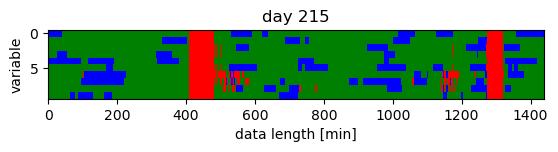

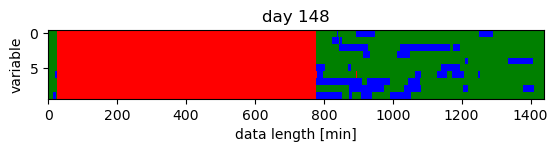

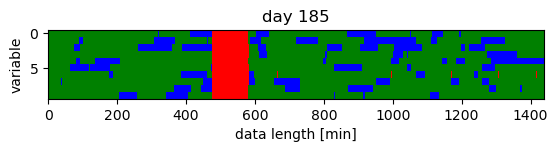

In [54]:
for i in range(5):
    day = np.random.choice(n_days, 1)[0]
    visualize_mask(masker(data_daily[day], lm=lm, masking_ratio=r))

## Test on actual mean of data

In [57]:
test_imputation_methods(data_daily, lm=lm, masking_ratio=r)

[('nearest', (0.5083644934234958, 0.001839382851107746)),
 ('linear', (0.5230483201522551, 0.001892512405635893)),
 ('spline', (0.5432733990534853, 0.001965691519784278)),
 ('median', (0.5602454942578904, 0.0020271005703183095)),
 ('mode', (0.5762568469234104, 0.002085033427347059)),
 ('mean', (0.6300930530372725, 0.0022798255412251737)),
 ('quadratic', (19.49417889525959, 0.0705345452332682))]

# Transformer imputation

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
def plotter_from_array(dat):
    """
    Same as plotter(day, dat) but here dat is array of daily data (shape: [1, 1440, 10])
    """
    if not isinstance(dat, np.ndarray):
        dat = dat.detach().numpy()

    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    batch_size, length, variables = dat.shape
    assert batch_size == 1 and length == 1440 and variables == 10

    # TODO: not sure if correct VARIABLES if we discard in import
    for i, variable in enumerate(VARIABLES):
        time_series = dat[:, :, i].reshape(-1)

        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series)
        plt.xlim([0, length])

Transformer model

In [8]:
sequence_length = 48 # max: 1440 (full day)
d_model = 16
n_heads = 4
n_encoder_layers = 3
lm = 43
r = 0.21

In [9]:
# TODO: check parameters
model = TSTransformerEncoder(feat_dim=len(VARIABLES),
                             max_len=sequence_length,
                             d_model=d_model,
                             n_heads=n_heads,
                             num_layers=n_encoder_layers,
                             dim_feedforward=d_model,
                             dropout=0.1,
                             pos_encoding='fixed',
                             activation='gelu',
                             norm='BatchNorm',
                             freeze=False)

model = model.to(device)

In [10]:
model

TSTransformerEncoder(
  (dropout1): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=16, out_features=10, bias=True)
  (project_inp): Linear(in_features=10, out_features=16, bias=True)
  (pos_enc): FixedPositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (linear1): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=16, out_features=16, bias=True)
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, a

In [11]:
sum(p.numel() for p in model.parameters()) # TODO: less params (?) (or pruning afterwards?)

5434

Data

In [12]:
# train-test split (TODO: + val?)
from sklearn.model_selection import train_test_split

n_days = len(data_daily)
train_indices, test_indices = train_test_split(np.arange(n_days))

Training model

In [13]:
# mask on-the-fly? -> model sees more data

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [15]:
criterion = MaskedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
'''# TODO: for now use batch_size = 1
# TODO: use dataloader?
# TODO: on GPU?
# TODO: evaluate only on purposefully set to NaN?
epochs = 50

model.train() # set model into training mode

history = {'train_loss': []}

print(f'Starting training for {epochs} epochs')
for epoch in range(epochs):
    # loss, metrics
    epoch_loss = 0.0

    # batches
    for i, batch_index in enumerate(tqdm(train_indices)):
        # load training batch
        batch = data_daily[batch_index].copy()

        # create mask (on-the-fly) # 0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning)
        mask = masker(batch, lm=43, masking_ratio=0.21)

        # reshape
        mask = mask.transpose()
        batch = batch.transpose().to_numpy() # pandas -> numpy + reshape

        # mask missing data
        y_true = torch.tensor(batch).unsqueeze(0).float().to(device) # target values shouldn't be masked
        batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
        batch = torch.tensor(batch).unsqueeze(0).float().to(device) # array -> tensor + add batch dimension
        X = batch

        # predict
        y_pred = model(X, padding_masks=torch.ones(1, 1440).bool().to(device)) # padding mask all True

        # update model
        mask = torch.tensor(mask == 1.0).unsqueeze(0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        #mask = torch.tensor(mask != 2.0).unsqueeze(0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        loss = criterion(y_pred, y_true, mask=mask)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()

        # on epoch end shuffle data
        np.random.shuffle(train_indices)

    # save data
    with torch.no_grad():
        history['train_loss'].append(epoch_loss)

    # print
    print(f'Epochs {epoch + 1}/{epochs} - loss: {epoch_loss}')'''

"# TODO: for now use batch_size = 1\n# TODO: use dataloader?\n# TODO: on GPU?\n# TODO: evaluate only on purposefully set to NaN?\nepochs = 50\n\nmodel.train() # set model into training mode\n\nhistory = {'train_loss': []}\n\nprint(f'Starting training for {epochs} epochs')\nfor epoch in range(epochs):\n    # loss, metrics\n    epoch_loss = 0.0\n\n    # batches\n    for i, batch_index in enumerate(tqdm(train_indices)):\n        # load training batch\n        batch = data_daily[batch_index].copy()\n\n        # create mask (on-the-fly) # 0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning)\n        mask = masker(batch, lm=43, masking_ratio=0.21)\n\n        # reshape\n        mask = mask.transpose()\n        batch = batch.transpose().to_numpy() # pandas -> numpy + reshape\n\n        # mask missing data\n        y_true = torch.tensor(batch).unsqueeze(0).float().to(device) # target values shouldn't be masked\n        batch[mask.astype(bool)] = 0.0 # missing data 

In [17]:
%%time
# segment day into sequences and treat as batches

# TODO: for now use batch_size daily - good enough?
# TODO: use dataloader?
# TODO: evaluate only on purposefully set to NaN?
epochs = 50

model.train() # set model into training mode

#scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5) # learning rate scheduler

history = {'train_loss': [],
           'test_loss': []}

print(f'Starting training for {epochs} epochs')
for epoch in range(epochs):
    # loss, metrics
    epoch_loss = 0.0
    epoch_loss_test = 0.0

    # training in batches
    for i, batch_index in enumerate(tqdm(train_indices)):
        # load training batch
        full_day = data_daily[batch_index].copy()

        # create mask (on-the-fly) (0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning))
        mask = masker(full_day, lm=lm, masking_ratio=r)

        # reshape
        full_day = full_day.transpose().to_numpy() # pandas -> numpy + reshape
        mask = mask.transpose()

        # split day into batches
        n_batches = full_day.shape[0] // sequence_length
        batch = np.array([full_day[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])
        mask = np.array([mask[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])

        # mask missing data
        y_true = torch.tensor(batch).float().to(device) # target values shouldn't be masked
        batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
        batch = torch.tensor(batch).float().to(device) # array -> tensor + add batch dimension
        X = batch

        # predict
        optimizer.zero_grad()
        y_pred = model(X, padding_masks=torch.ones(n_batches, sequence_length).bool().to(device)) # padding mask all True

        # update model
        mask = torch.tensor(mask == 1.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        #mask = torch.tensor(mask != 2.0).unsqueeze(0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        loss = criterion(y_pred, y_true, mask=mask)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()

        # on epoch end shuffle data
        np.random.shuffle(train_indices)

    # validation in batches
    with torch.no_grad():
        for i, batch_index in enumerate(test_indices):
            # load training batch
            full_day = data_daily[batch_index].copy()

            # create mask (on-the-fly) (0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning))
            mask = masker(full_day, lm=43, masking_ratio=0.21)

            # reshape
            full_day = full_day.transpose().to_numpy() # pandas -> numpy + reshape
            mask = mask.transpose()

            # split day into batches
            n_batches = full_day.shape[0] // sequence_length
            batch = np.array([full_day[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])
            mask = np.array([mask[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])

            # mask missing data
            y_true = torch.tensor(batch).float().to(device) # target values shouldn't be masked
            batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
            batch = torch.tensor(batch).float().to(device) # array -> tensor + add batch dimension
            X = batch

            # predict
            y_pred = model(X, padding_masks=torch.ones(n_batches, sequence_length).bool().to(device)) # padding mask all True

            # update model
            mask = torch.tensor(mask == 1.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
            #mask = torch.tensor(mask != 2.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
            loss = criterion(y_pred, y_true, mask=mask)
            epoch_loss_test += loss.item()

            # on epoch end shuffle data
            np.random.shuffle(test_indices)

    # save data
    with torch.no_grad():
        history['train_loss'].append(epoch_loss / len(train_indices))
        history['test_loss'].append(epoch_loss_test / len(test_indices))

    # print
    print(f'Epochs {epoch + 1}/{epochs} - train loss: {epoch_loss}, test loss: {epoch_loss_test}')

Starting training for 50 epochs


100%|██████████| 306/306 [00:13<00:00, 23.29it/s]


Epochs 1/50 - train loss: 282.82341250777245, test loss: 85.5774017572403


100%|██████████| 306/306 [00:11<00:00, 26.70it/s]


Epochs 2/50 - train loss: 252.27790287137032, test loss: 83.18572643399239


100%|██████████| 306/306 [00:10<00:00, 28.10it/s]


Epochs 3/50 - train loss: 246.44798931479454, test loss: 78.69622176885605


100%|██████████| 306/306 [00:10<00:00, 28.13it/s]


Epochs 4/50 - train loss: 224.75254905223846, test loss: 79.99804988503456


100%|██████████| 306/306 [00:10<00:00, 28.27it/s]


Epochs 5/50 - train loss: 227.9354401230812, test loss: 75.86493772268295


100%|██████████| 306/306 [00:11<00:00, 26.61it/s]


Epochs 6/50 - train loss: 225.2046875357628, test loss: 76.51758763194084


100%|██████████| 306/306 [00:10<00:00, 28.14it/s]


Epochs 7/50 - train loss: 229.61804589629173, test loss: 75.34009355306625


100%|██████████| 306/306 [00:11<00:00, 27.78it/s]


Epochs 8/50 - train loss: 217.77336278557777, test loss: 73.99009966850281


100%|██████████| 306/306 [00:10<00:00, 28.02it/s]


Epochs 9/50 - train loss: 221.04313161969185, test loss: 73.05834582448006


100%|██████████| 306/306 [00:10<00:00, 27.96it/s]


Epochs 10/50 - train loss: 218.06286868453026, test loss: 71.66012528538704


100%|██████████| 306/306 [00:11<00:00, 26.23it/s]


Epochs 11/50 - train loss: 210.65208542346954, test loss: 72.72366055846214


100%|██████████| 306/306 [00:12<00:00, 24.92it/s]


Epochs 12/50 - train loss: 217.93737921118736, test loss: 71.78299048542976


100%|██████████| 306/306 [00:11<00:00, 27.42it/s]


Epochs 13/50 - train loss: 214.61410257220268, test loss: 71.73721441626549


100%|██████████| 306/306 [00:10<00:00, 28.52it/s]


Epochs 14/50 - train loss: 208.98031029105186, test loss: 69.34877359867096


100%|██████████| 306/306 [00:10<00:00, 27.87it/s]


Epochs 15/50 - train loss: 213.4029105603695, test loss: 68.59249261021614


100%|██████████| 306/306 [00:11<00:00, 26.56it/s]


Epochs 16/50 - train loss: 214.0285423696041, test loss: 72.0079824924469


100%|██████████| 306/306 [00:12<00:00, 24.56it/s]


Epochs 17/50 - train loss: 209.3007871210575, test loss: 68.93758949637413


100%|██████████| 306/306 [00:11<00:00, 27.49it/s]


Epochs 18/50 - train loss: 205.1858964562416, test loss: 72.82437652349472


100%|██████████| 306/306 [00:10<00:00, 27.91it/s]


Epochs 19/50 - train loss: 206.193349391222, test loss: 70.32819640636444


100%|██████████| 306/306 [00:10<00:00, 28.40it/s]


Epochs 20/50 - train loss: 206.93880861997604, test loss: 69.68880993127823


100%|██████████| 306/306 [00:10<00:00, 28.29it/s]


Epochs 21/50 - train loss: 205.66814821958542, test loss: 71.98312151432037


100%|██████████| 306/306 [00:10<00:00, 28.08it/s]


Epochs 22/50 - train loss: 205.34821939468384, test loss: 67.68695819377899


100%|██████████| 306/306 [00:10<00:00, 28.47it/s]


Epochs 23/50 - train loss: 204.23605072498322, test loss: 71.2649938762188


100%|██████████| 306/306 [00:10<00:00, 28.36it/s]


Epochs 24/50 - train loss: 206.46650576591492, test loss: 73.77211764454842


100%|██████████| 306/306 [00:10<00:00, 27.96it/s]


Epochs 25/50 - train loss: 202.52987948060036, test loss: 68.10885027050972


100%|██████████| 306/306 [00:10<00:00, 28.02it/s]


Epochs 26/50 - train loss: 207.24339589476585, test loss: 70.4693224132061


100%|██████████| 306/306 [00:10<00:00, 28.14it/s]


Epochs 27/50 - train loss: 211.0334806740284, test loss: 68.50337845087051


100%|██████████| 306/306 [00:10<00:00, 28.51it/s]


Epochs 28/50 - train loss: 199.5363625586033, test loss: 68.59304732084274


100%|██████████| 306/306 [00:11<00:00, 27.34it/s]


Epochs 29/50 - train loss: 202.34486663341522, test loss: 65.99966108798981


100%|██████████| 306/306 [00:10<00:00, 28.56it/s]


Epochs 30/50 - train loss: 198.57289651036263, test loss: 69.69048598408699


100%|██████████| 306/306 [00:10<00:00, 28.60it/s]


Epochs 31/50 - train loss: 199.5171504020691, test loss: 66.69193211197853


100%|██████████| 306/306 [00:10<00:00, 28.65it/s]


Epochs 32/50 - train loss: 193.98571234941483, test loss: 70.92735204100609


100%|██████████| 306/306 [00:10<00:00, 28.81it/s]


Epochs 33/50 - train loss: nan, test loss: 68.05053994059563


100%|██████████| 306/306 [00:10<00:00, 28.87it/s]


Epochs 34/50 - train loss: 194.84813523292542, test loss: 67.64917001128197


100%|██████████| 306/306 [00:10<00:00, 28.79it/s]


Epochs 35/50 - train loss: 196.66853111982346, test loss: 67.6614488363266


100%|██████████| 306/306 [00:10<00:00, 28.66it/s]


Epochs 36/50 - train loss: 201.32212734222412, test loss: 70.37455055117607


100%|██████████| 306/306 [00:10<00:00, 28.54it/s]


Epochs 37/50 - train loss: 199.88378828763962, test loss: 64.64196881651878


100%|██████████| 306/306 [00:10<00:00, 28.61it/s]


Epochs 38/50 - train loss: 196.78564423322678, test loss: 66.30643072724342


100%|██████████| 306/306 [00:10<00:00, 28.96it/s]


Epochs 39/50 - train loss: 198.32580382190645, test loss: 70.91385626792908


100%|██████████| 306/306 [00:10<00:00, 28.95it/s]


Epochs 40/50 - train loss: 196.4937754366547, test loss: 69.42146727442741


100%|██████████| 306/306 [00:10<00:00, 28.54it/s]


Epochs 41/50 - train loss: 201.15439119935036, test loss: 66.97823256254196


100%|██████████| 306/306 [00:10<00:00, 28.79it/s]


Epochs 42/50 - train loss: 196.52289044857025, test loss: 67.23960322141647


100%|██████████| 306/306 [00:10<00:00, 28.56it/s]


Epochs 43/50 - train loss: 199.91710323095322, test loss: 67.37935161590576


100%|██████████| 306/306 [00:10<00:00, 28.85it/s]


Epochs 44/50 - train loss: 196.2012357711792, test loss: 65.14270243048668


100%|██████████| 306/306 [00:10<00:00, 28.67it/s]


Epochs 45/50 - train loss: 193.47135046124458, test loss: 65.58823102712631


100%|██████████| 306/306 [00:10<00:00, 28.83it/s]


Epochs 46/50 - train loss: 197.7321022450924, test loss: 67.68025502562523


100%|██████████| 306/306 [00:11<00:00, 26.02it/s]


Epochs 47/50 - train loss: 196.09319061040878, test loss: 65.82523679733276


100%|██████████| 306/306 [00:11<00:00, 27.81it/s]


Epochs 48/50 - train loss: 193.06355276703835, test loss: 66.43382734060287


100%|██████████| 306/306 [00:10<00:00, 28.43it/s]


Epochs 49/50 - train loss: 194.41941019892693, test loss: 66.96698173880577


100%|██████████| 306/306 [00:10<00:00, 28.24it/s]


Epochs 50/50 - train loss: 196.3584761619568, test loss: 66.31155002117157
CPU times: total: 11min 25s
Wall time: 11min 25s


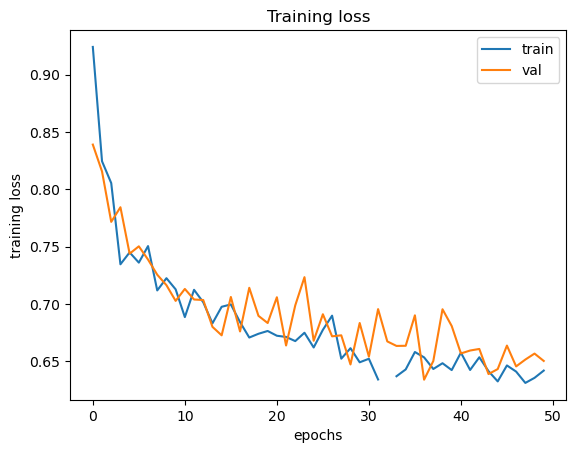

In [18]:
plt.plot(history['train_loss'])
plt.plot(history['test_loss'])
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.title('Training loss')
plt.legend(['train', 'val'])

# Check if transformer can output identity (since it seems to output just constants by variables which seems weird)

In [170]:
%%time
# segment day into sequences and treat as batches

# TODO: for now use batch_size daily - good enough?
# TODO: use dataloader?
# TODO: evaluate only on purposefully set to NaN?
epochs = 50

model.train() # set model into training mode

history = {'train_loss': [],
           'test_loss': []}

print(f'Starting training for {epochs} epochs')
for epoch in range(epochs):
    # loss, metrics
    epoch_loss = 0.0
    epoch_loss_test = 0.0

    # training in batches
    for i, batch_index in enumerate(tqdm(train_indices)):
        # load training batch
        full_day = data_daily[batch_index].copy()

        # create mask (on-the-fly) (0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning))
        mask = masker(full_day, lm=lm, masking_ratio=r)
        mask[mask == 1] = 0

        # reshape
        full_day = full_day.transpose().to_numpy() # pandas -> numpy + reshape
        mask = mask.transpose()

        # split day into batches
        n_batches = full_day.shape[0] // sequence_length
        batch = np.array([full_day[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])
        mask = np.array([mask[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])

        # mask missing data
        y_true = torch.tensor(batch).float().to(device) # target values shouldn't be masked
        batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
        batch = torch.tensor(batch).float().to(device) # array -> tensor + add batch dimension
        X = batch

        # predict
        y_pred = model(X, padding_masks=torch.ones(n_batches, sequence_length).bool().to(device)) # padding mask all True

        # update model
        mask = torch.tensor(mask != 2.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        loss = criterion(y_pred, y_true, mask=mask)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()

        # on epoch end shuffle data
        np.random.shuffle(train_indices)

    # validation in batches
    for i, batch_index in enumerate(test_indices):
        with torch.no_grad():
            # load training batch
            full_day = data_daily[batch_index].copy()

            # create mask (on-the-fly) (0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning))
            mask = masker(full_day, lm=lm, masking_ratio=r)
            mask[mask == 1] = 0

            # reshape
            full_day = full_day.transpose().to_numpy() # pandas -> numpy + reshape
            mask = mask.transpose()

            # split day into batches
            n_batches = full_day.shape[0] // sequence_length
            batch = np.array([full_day[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])
            mask = np.array([mask[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])

            # mask missing data
            y_true = torch.tensor(batch).float().to(device) # target values shouldn't be masked
            batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
            batch = torch.tensor(batch).float().to(device) # array -> tensor + add batch dimension
            X = batch

            # predict
            y_pred = model(X, padding_masks=torch.ones(n_batches, sequence_length).bool().to(device)) # padding mask all True

            # update model
            mask = torch.tensor(mask != 2.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
            loss = criterion(y_pred, y_true, mask=mask)
            epoch_loss_test += loss.item()

            # on epoch end shuffle data
            np.random.shuffle(test_indices)

    # save data
    with torch.no_grad():
        history['train_loss'].append(epoch_loss / len(train_indices))
        history['test_loss'].append(epoch_loss_test / len(test_indices))

    # print
    print(f'Epochs {epoch + 1}/{epochs} - train loss: {epoch_loss}, test loss: {epoch_loss_test}')

Starting training for 50 epochs


100%|██████████| 306/306 [00:12<00:00, 24.90it/s]


Epochs 1/50 - train loss: 220.72072538733482, test loss: 75.2471034526825


100%|██████████| 306/306 [00:11<00:00, 26.02it/s]


Epochs 2/50 - train loss: 260.16085892915726, test loss: 92.23213839530945


100%|██████████| 306/306 [00:11<00:00, 25.52it/s]


Epochs 3/50 - train loss: 277.8725101351738, test loss: 93.05065190792084


100%|██████████| 306/306 [00:12<00:00, 25.03it/s]


Epochs 4/50 - train loss: 279.818405687809, test loss: 93.76525765657425


100%|██████████| 306/306 [00:11<00:00, 26.44it/s]


Epochs 5/50 - train loss: 288.2053560614586, test loss: 106.22128528356552


100%|██████████| 306/306 [00:11<00:00, 26.39it/s]


Epochs 6/50 - train loss: 314.07151848077774, test loss: 106.06589943170547


100%|██████████| 306/306 [00:11<00:00, 26.92it/s]


Epochs 7/50 - train loss: 326.82684445381165, test loss: 111.72773402929306


100%|██████████| 306/306 [00:11<00:00, 26.92it/s]


Epochs 8/50 - train loss: 325.0788988471031, test loss: 112.39921772480011


100%|██████████| 306/306 [00:11<00:00, 26.95it/s]


Epochs 9/50 - train loss: 327.77142161130905, test loss: 111.53328388929367


100%|██████████| 306/306 [00:11<00:00, 26.65it/s]


Epochs 10/50 - train loss: 325.21434992551804, test loss: 111.42491841316223


100%|██████████| 306/306 [00:11<00:00, 26.04it/s]


Epochs 11/50 - train loss: 324.29221588373184, test loss: 107.62486296892166


100%|██████████| 306/306 [00:11<00:00, 26.50it/s]


Epochs 12/50 - train loss: 325.31227338314056, test loss: 108.34727662801743


100%|██████████| 306/306 [00:11<00:00, 26.01it/s]


Epochs 13/50 - train loss: 312.81410378217697, test loss: 104.87112736701965


100%|██████████| 306/306 [00:11<00:00, 26.56it/s]


Epochs 14/50 - train loss: 317.0982453227043, test loss: 104.54180324077606


100%|██████████| 306/306 [00:11<00:00, 26.96it/s]


Epochs 15/50 - train loss: 316.1628069281578, test loss: 103.91256141662598


100%|██████████| 306/306 [00:11<00:00, 27.27it/s]


Epochs 16/50 - train loss: 305.90581744909286, test loss: 102.28829783201218


100%|██████████| 306/306 [00:11<00:00, 27.16it/s]


Epochs 17/50 - train loss: 315.5242850780487, test loss: 105.12116813659668


100%|██████████| 306/306 [00:11<00:00, 27.28it/s]


Epochs 18/50 - train loss: 309.5611729621887, test loss: 103.86579889059067


100%|██████████| 306/306 [00:11<00:00, 26.48it/s]


Epochs 19/50 - train loss: 309.8842763900757, test loss: 103.1926851272583


100%|██████████| 306/306 [00:11<00:00, 26.72it/s]


Epochs 20/50 - train loss: 306.56994169950485, test loss: 103.13170236349106


100%|██████████| 306/306 [00:11<00:00, 27.59it/s]


Epochs 21/50 - train loss: 308.58548974990845, test loss: 103.0484961271286


100%|██████████| 306/306 [00:11<00:00, 26.84it/s]


Epochs 22/50 - train loss: 309.53157937526703, test loss: 103.3208058476448


100%|██████████| 306/306 [00:11<00:00, 27.09it/s]


Epochs 23/50 - train loss: 306.8888655304909, test loss: 103.31661778688431


100%|██████████| 306/306 [00:11<00:00, 26.97it/s]


Epochs 24/50 - train loss: 307.852028131485, test loss: 100.9025410413742


100%|██████████| 306/306 [00:11<00:00, 26.46it/s]


Epochs 25/50 - train loss: 307.5235140323639, test loss: 104.05838799476624


100%|██████████| 306/306 [00:11<00:00, 27.36it/s]


Epochs 26/50 - train loss: 310.0984430909157, test loss: 103.9505450129509


100%|██████████| 306/306 [00:11<00:00, 27.00it/s]


Epochs 27/50 - train loss: 312.0224167108536, test loss: 104.89626783132553


100%|██████████| 306/306 [00:11<00:00, 26.62it/s]


Epochs 28/50 - train loss: 310.9159622192383, test loss: 105.65591430664062


100%|██████████| 306/306 [00:11<00:00, 26.98it/s]


Epochs 29/50 - train loss: 393.59698712825775, test loss: 106.2969542145729


100%|██████████| 306/306 [00:11<00:00, 26.65it/s]


Epochs 30/50 - train loss: 312.50873225927353, test loss: 104.99070465564728


100%|██████████| 306/306 [00:11<00:00, 26.72it/s]


Epochs 31/50 - train loss: 319.73266834020615, test loss: 104.9103969335556


100%|██████████| 306/306 [00:11<00:00, 27.13it/s]


Epochs 32/50 - train loss: 315.64223259687424, test loss: 106.95877397060394


100%|██████████| 306/306 [00:11<00:00, 27.32it/s]


Epochs 33/50 - train loss: 317.3816390633583, test loss: 104.23636901378632


100%|██████████| 306/306 [00:11<00:00, 26.92it/s]


Epochs 34/50 - train loss: 317.8947076201439, test loss: 106.93456250429153


100%|██████████| 306/306 [00:11<00:00, 26.92it/s]


Epochs 35/50 - train loss: 316.33432471752167, test loss: 104.1169980764389


100%|██████████| 306/306 [00:11<00:00, 26.87it/s]


Epochs 36/50 - train loss: 314.0937514901161, test loss: 105.26360684633255


100%|██████████| 306/306 [00:11<00:00, 26.52it/s]


Epochs 37/50 - train loss: 315.1213952302933, test loss: 104.7507032752037


100%|██████████| 306/306 [00:11<00:00, 26.95it/s]


Epochs 38/50 - train loss: 314.84035301208496, test loss: 105.0904466509819


100%|██████████| 306/306 [00:11<00:00, 27.00it/s]


Epochs 39/50 - train loss: 314.60612320899963, test loss: 104.07131445407867


100%|██████████| 306/306 [00:11<00:00, 27.00it/s]


Epochs 40/50 - train loss: 316.23323887586594, test loss: 105.23717123270035


100%|██████████| 306/306 [00:11<00:00, 26.89it/s]


Epochs 41/50 - train loss: 314.1015720963478, test loss: 105.18188410997391


100%|██████████| 306/306 [00:11<00:00, 26.53it/s]


Epochs 42/50 - train loss: 317.45452266931534, test loss: 105.12554687261581


100%|██████████| 306/306 [00:11<00:00, 27.03it/s]


Epochs 43/50 - train loss: 312.70307099819183, test loss: 106.37071752548218


100%|██████████| 306/306 [00:11<00:00, 27.07it/s]


Epochs 44/50 - train loss: 319.10605269670486, test loss: 104.32086539268494


100%|██████████| 306/306 [00:11<00:00, 27.06it/s]


Epochs 45/50 - train loss: 314.36890548467636, test loss: 105.70200371742249


100%|██████████| 306/306 [00:11<00:00, 27.09it/s]


Epochs 46/50 - train loss: 318.86493265628815, test loss: 105.80533134937286


100%|██████████| 306/306 [00:11<00:00, 26.87it/s]


Epochs 47/50 - train loss: 315.30748760700226, test loss: 105.69867515563965


100%|██████████| 306/306 [00:11<00:00, 26.40it/s]


Epochs 48/50 - train loss: 320.82029616832733, test loss: 106.19145405292511


100%|██████████| 306/306 [00:11<00:00, 26.89it/s]


Epochs 49/50 - train loss: 349.27022832632065, test loss: 105.23560267686844


100%|██████████| 306/306 [00:11<00:00, 26.58it/s]


Epochs 50/50 - train loss: 318.09011048078537, test loss: 107.02473628520966
CPU times: total: 11min 52s
Wall time: 11min 55s


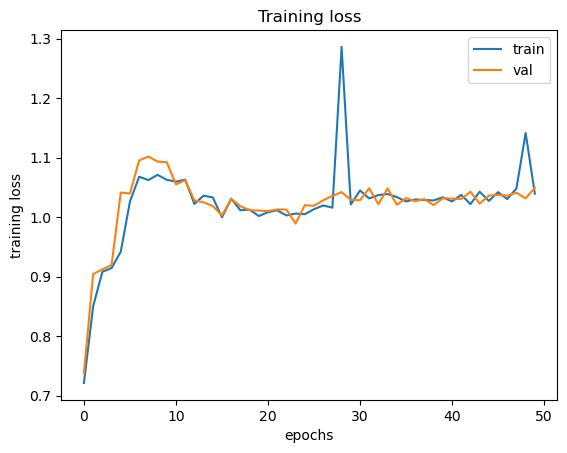

In [174]:
plt.plot(history['train_loss'])
plt.plot(history['test_loss'])
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.title('Training loss')
plt.legend(['train', 'val'])

In [172]:
day = np.random.choice(test_indices, 1)[0]
day

124

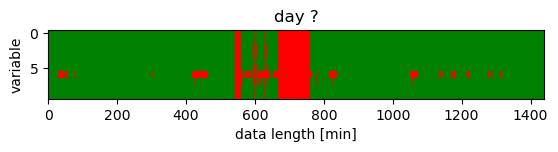

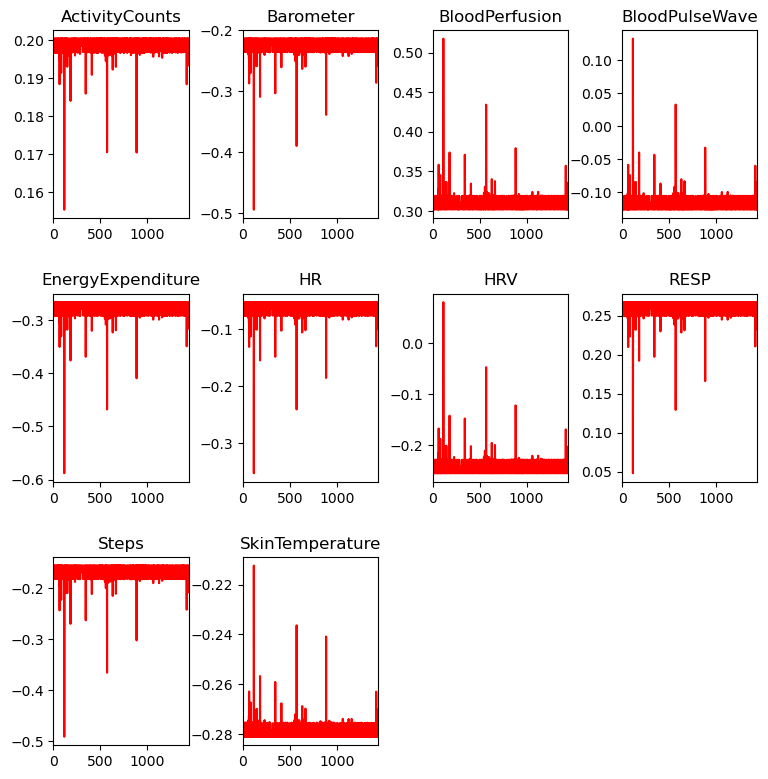

In [173]:
show_prediction(model, data_daily, day, lm=lm, r=r, show_mask=True, prediction_only=True)

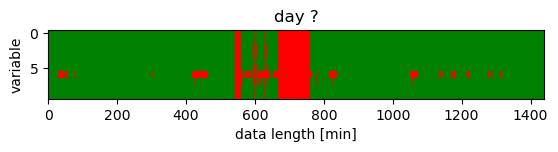

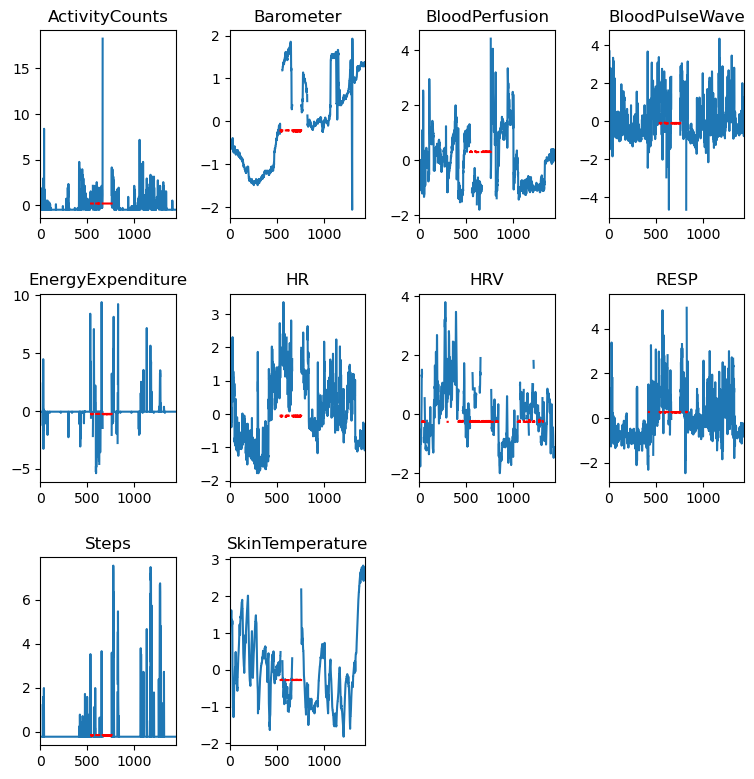

In [175]:
show_prediction(model, data_daily, day, lm=lm, r=r, show_mask=True, prediction_only=False)

Evaluation model

### Visual inspection

# TODO: output constant? (by variable)

In [138]:
def show_prediction(model, dat, day, lm, r, show_mask=True, show_mask_plot=False,
                    prediction_only=False, full_prediction=False):
    with torch.no_grad():
        full_day = dat[day].copy()
        mask = masker(full_day, lm=lm, masking_ratio=r)
        mask[mask == 1] = 0 # we don't mask additional segments during testing

        # reshape
        full_day = full_day.transpose().to_numpy() # pandas -> numpy + reshape
        mask = mask.transpose()

        # split day into batches
        n_batches = full_day.shape[0] // sequence_length
        batch = np.array([full_day[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])
        mask = np.array([mask[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])

        # mask missing data
        y_true = torch.tensor(batch).float().to(device) # target values shouldn't be masked
        batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
        batch = torch.tensor(batch).float().to(device) # array -> tensor + add batch dimension
        X = batch

        # predict
        y_pred = model(X, padding_masks=torch.ones(n_batches, sequence_length).bool().to(device)) # padding mask all True

        # put back into cpu
        y_true = y_true.to('cpu')
        y_pred = y_pred.to('cpu')

        # concatenate batches into full day sequence
        y = y_true[0, :, :].numpy()
        for i in range(1, y_true.shape[0]):
            y = np.concatenate((y, y_true[i, :, :].numpy()), axis=0)
        y = y.transpose()

        yp = y_pred[0, :, :].detach().numpy()
        for i in range(1, y_pred.shape[0]):
            yp = np.concatenate((yp, y_pred[i, :, :].detach().numpy()), axis=0)
        yp = yp.transpose()

        m = mask[0, :, :]
        for i in range(1, mask.shape[0]):
            m = np.concatenate((m, mask[i, :, :]), axis=0)
        m = m.transpose()

        # visualize mask
        if show_mask:
            visualize_mask(m)

        # plot imputation
        plt.figure()
        plt.subplots_adjust(left=0.1,
                            bottom=0.01,
                            right=1.2,
                            top=1.5,
                            wspace=0.4,
                            hspace=0.4)

        if prediction_only:
            for i, variable in enumerate(VARIABLES):
                mask_variable = m[i, :] # 0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning)
                time_series_imputed = yp[i, :]
                if not full_prediction:
                    time_series_imputed[mask_variable != 2] = np.NaN # remove data we know anyway

                plt.subplot(3, 4, i+1)
                if show_mask_plot:
                    y_min, y_max = np.nanmin(time_series_imputed), np.nanmax(time_series_imputed)
                    masked = mask_variable != 0
                    # build continuous masking sequences for plot
                    seq = []
                    for j in range(len(masked)):
                        if masked[j]: # True means datapoint is masked
                            seq.append(j)
                        else:
                            if len(seq) != 0:
                                # plot background
                                plt.axhspan(y_min, y_max, seq[0] / 1440, seq[-1] / 1440, facecolor='grey', alpha=0.2)
                                seq = []
                plt.title(variable)
                plt.plot(time_series_imputed, color='red', linewidth=1)
                plt.xlim([0, 1440])
                plt.plot()
        else:
            for i, variable in enumerate(VARIABLES):
                mask_variable = m[i, :] # 0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning)
                time_series = y[i, :]
                time_series_imputed = yp[i, :]
                if not full_prediction:
                    time_series_imputed[mask_variable != 2] = np.NaN # remove data we know anyway

                plt.subplot(3, 4, i+1)
                if show_mask_plot:
                    y_min, y_max = min(np.nanmin(time_series), np.nanmin(time_series_imputed)), \
                                   max(np.nanmax(time_series), np.nanmax(time_series_imputed))
                    masked = mask_variable != 0
                    # build continuous masking sequences for plot
                    seq = []
                    for j in range(len(masked)):
                        if masked[j]: # True means datapoint is masked
                            seq.append(j)
                        else:
                            if len(seq) != 0:
                                # plot background
                                plt.axhspan(y_min, y_max, seq[0] / 1440, seq[-1] / 1440, facecolor='grey', alpha=0.2)
                                seq = []
                plt.title(variable)
                plt.plot(time_series, linewidth=1)
                plt.plot(time_series_imputed, color='red', linewidth=1)
                plt.xlim([0, 1440])
                plt.plot()

In [139]:
day = np.random.choice(test_indices, 1)[0]
day

165

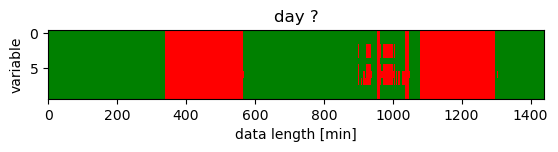

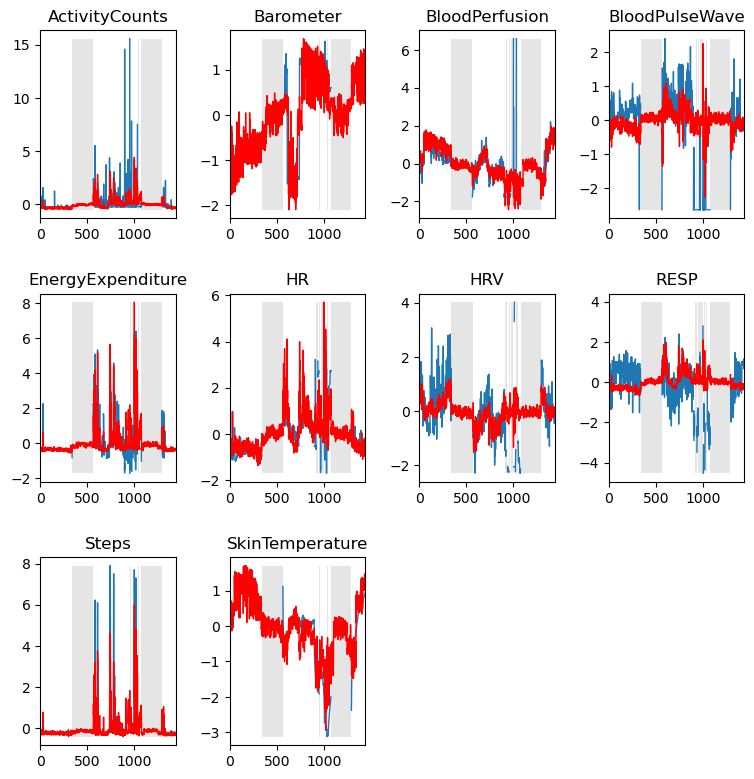

In [142]:
show_prediction(model, data_daily, day, lm=lm, r=r, show_mask=True, show_mask_plot=True, prediction_only=False, full_prediction=True)

### Test on training set

In [31]:
len(test_indices)

102

In [33]:
test_imputation_methods([data_daily[i] for i in test_indices], lm=lm, masking_ratio=r)

[('linear', (0.5982083425546743, 0.005563715287481225)),
 ('spline', (0.6249373287607262, 0.0058123117355655205)),
 ('nearest', (0.6299987235955238, 0.005859385903234401)),
 ('median', (0.7203551410496027, 0.006699757635538266)),
 ('mean', (0.7689314779430373, 0.0071515482391758915)),
 ('mode', (1.0161900775768122, 0.009451209331946259)),
 ('quadratic', (7.100400188523173, 0.06603820486256486))]